In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from dsk.pickle import load_pkl
import numpy as np
import torch
from tqdm import tqdm
from deeporb.data_gen import OrbExtract
from deeporb.data import OrbDataset, OrbData
import os
import glob
import h5py
from pyscf.tools import molden
from pyscf import gto, scf
import matplotlib.pyplot as plt
import numpy as np

#Energy model
from deeporb.default_net import default_net_task
chkpt = "../model_eval/local_models/epoch=749-step=300000.ckpt"
occ_data_name = "sto3g_occ"
occ_task = default_net_task(mean_std=occ_data_name,chkpt=chkpt)
occ_task.model.cuda();

/home/king1305/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/king1305/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loading model from ../model_eval/local_models/epoch=749-step=300000.ckpt ...
Loading successful!


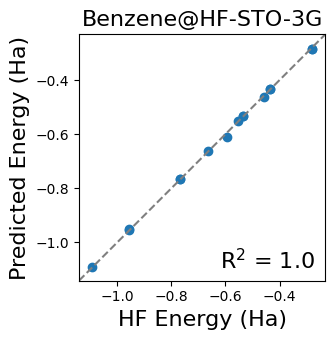

In [5]:
class benzene_loc():
    def __init__(self,head_dir="../model_eval/benzene/"):
        self.model = occ_task.model
        
    def get_data(self,h5fn):
        from deeporb.default_net import mean_std_dct
        avge0,sigma = mean_std_dct["sto3g_occ"]
        data = OrbData(h5fn,batch_size=128,train_split=1,val_split=0,test_split=0,cutoff=7.6,avge0=avge0,sigma=sigma)
        data.setup()
        return data

    def make_predictions(self,h5fn):
        from cace.tools import scatter_sum
        from deeporb.default_net import mean_std_dct
        avge0,sigma = mean_std_dct["sto3g_occ"]
        data = self.get_data(h5fn=h5fn)
        with torch.no_grad():
            for batch in data.train_dataloader():
                batch.cuda()
                out = self.model(batch)
                pred_energy_occ = out["pred_energy"] * sigma + avge0
                true_energy_occ = batch["energy"]
                break
            for batch in data.train_dataloader():
                batch.cuda()
                Xrep_atom = self.model.model.representation(batch)["node_feats"]
                Xrep = scatter_sum(src=Xrep_atom,index=batch["batch"],dim=0)
                ones = torch.ones_like(batch["atomic_numbers"])
                num = scatter_sum(src=ones,index=batch["batch"],dim=0)
                Xrep = Xrep / num[:,None]
                ytot = batch["energy"]
                break
        self.Xrep = Xrep.cpu().detach().numpy()
        self.ytot = ytot.cpu().detach().numpy() #True energy
        pred_energy_occ = pred_energy_occ.cpu().detach().numpy()
        true_energy_occ = true_energy_occ.cpu().detach().numpy()
        torch.cuda.empty_cache()
        self.true = true_energy_occ
        self.pred = pred_energy_occ

    def plot_scatter(self,r2x=-0.6,r2y=-1.05,title=None):
        import scipy
        import matplotlib.pyplot as plt
        plt.figure(figsize=(3.5,3.5))
        r2 = np.round(scipy.stats.pearsonr(self.true,self.pred)[0]**2,3)
        arr = np.hstack([self.true,self.pred])
        mx,mn = arr.max(), arr.min()
        xmin, xmax = -0.05+mn, mx+0.05
        x = y = np.arange(xmin,xmax+1)
        plt.plot(x,y,linestyle="--",color="grey")
        plt.xlim(xmin,xmax)
        plt.ylim(xmin,xmax)
        s = 0.25
        fs=16
        djvfont = {'fontname':'DejaVu Sans'}
        plt.scatter(self.true,self.pred)
        plt.xlabel("HF Energy (Ha)",fontsize=fs,**djvfont)
        plt.ylabel("Predicted Energy (Ha)",fontsize=fs,**djvfont)
        plt.title(title,fontsize=fs,**djvfont)
        plt.text(r2x,r2y,f"R$^2$ = {r2}",fontsize=fs,**djvfont)
        plt.gca().set_aspect('equal')
        plt.tight_layout()
        
    def plot_pca(self,annotate=False,prnt=False,title=None):
        import matplotlib.pyplot as plt
        from sklearn.decomposition import PCA, KernelPCA
        plt.figure(figsize=(4,3.5))
        pca = PCA(n_components=4)
        s = 2
        A = pca.fit_transform(self.Xrep)
        cm = plt.cm.get_cmap('RdYlBu')
        sc = plt.scatter(A[:,0],A[:,1],c=self.ytot,cmap=cm)
        djvfont = {'fontname':'DejaVu Sans'}
        fs=16
        pc1, pc2 = np.round(pca.explained_variance_ratio_,2)[:2]
        s1 = f"PC 1 (" + str(pc1) + ")"
        s2 = f"PC 2 (" + str(pc2) + ")"
        lst = []
        if annotate:
            for i,row in enumerate(A):
                plt.annotate(f"{i}",(row[0]+0.01,row[1]+0.01))
                if prnt:
                    print(i,row[0],row[1])
                
        plt.xlabel(s1,fontsize=fs,**djvfont)
        plt.ylabel(s2,fontsize=fs,**djvfont)
        if not title:
            title = f"Benzene@{self.loc_name}-STO-3G"
        plt.title(title,fontsize=fs,**djvfont)
        plt.colorbar(label="HF Energy (Ha)")
        plt.tight_layout()

head_dir = "../model_eval/benzene/"
h5fn = f"{head_dir}/benzene_sto3g_occ.h5"
obj = benzene_loc()
obj.make_predictions(h5fn)
obj.plot_scatter(r2x=-0.62,r2y=-1.1,title="Benzene@HF-STO-3G")
plt.savefig("figures/benzene_hf_pred.png",dpi=500)

## PCA Plots

/tmp/ipykernel_3167647/4055643163.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


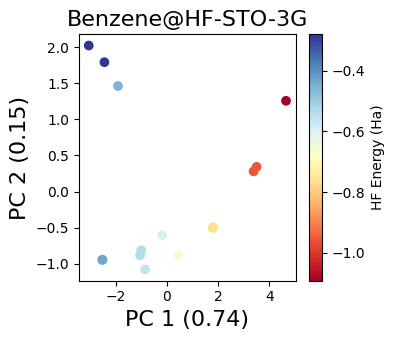

In [4]:
h5fn = f"{head_dir}/benzene_sto3g_occ.h5"
obj = benzene_loc()
obj.make_predictions(h5fn)
obj.plot_pca(annotate=False,title="Benzene@HF-STO-3G")
plt.savefig("figures/benzene_hf_pca.png",dpi=500)

/tmp/ipykernel_3167647/4055643163.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


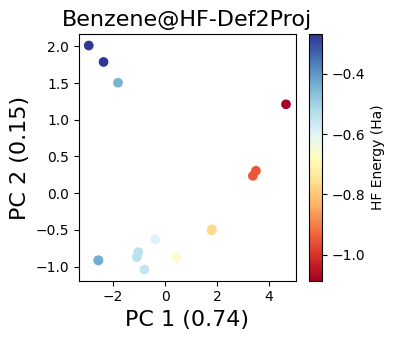

In [5]:
h5fn = f"{head_dir}/benzene_sto3g_proj_occ.h5"
obj = benzene_loc()
obj.make_predictions(h5fn)
obj.plot_pca(annotate=False,title="Benzene@HF-Def2Proj")
plt.savefig("figures/benzene_hf_proj_pca.png",dpi=500)

/tmp/ipykernel_3167647/4055643163.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


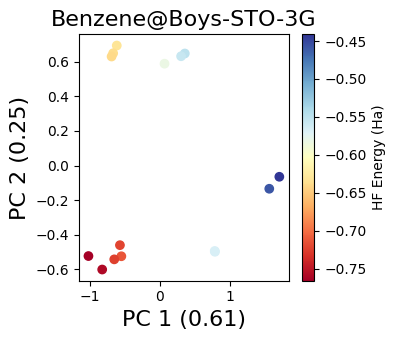

In [15]:
h5fn = f"{head_dir}/benzene_sto3g_occ_boys.h5"
obj = benzene_loc()
obj.make_predictions(h5fn)
obj.plot_pca(annotate=False,title="Benzene@Boys-STO-3G")
plt.savefig("figures/benzene_boys_pca.png",dpi=500)

/tmp/ipykernel_3167647/4055643163.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


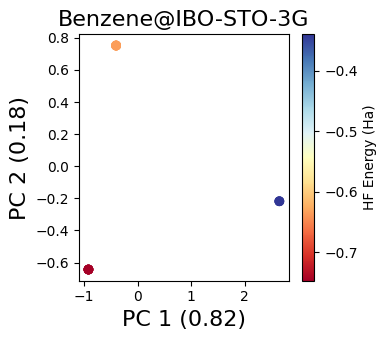

In [16]:
h5fn = f"{head_dir}/benzene_sto3g_occ_ibo.h5"
obj = benzene_loc()
obj.make_predictions(h5fn)
obj.plot_pca(annotate=False,title="Benzene@IBO-STO-3G")
plt.savefig("figures/benzene_ibo_pca.png",dpi=500)

## Scatter Plots

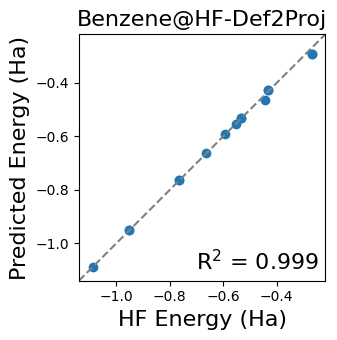

In [19]:
h5fn = f"{head_dir}/benzene_sto3g_proj_occ.h5"
obj = benzene_loc()
obj.make_predictions(h5fn)
obj.plot_scatter(r2x=-0.7,r2y=-1.1,title="Benzene@HF-Def2Proj")
plt.savefig("figures/benzene_hf_proj_pred.png",dpi=500)

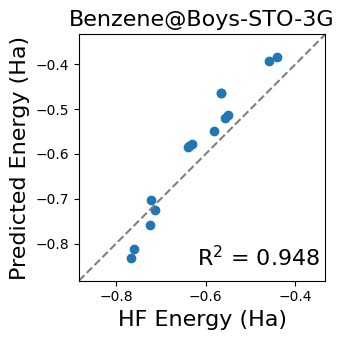

In [21]:
h5fn = f"{head_dir}/benzene_sto3g_occ_boys.h5"
obj = benzene_loc()
obj.make_predictions(h5fn)
obj.plot_scatter(r2x=-0.62,r2y=-0.85,title="Benzene@Boys-STO-3G")
plt.savefig("figures/benzene_boys_pred.png",dpi=500)

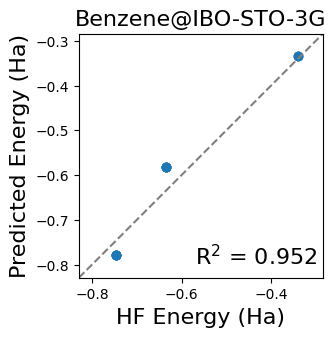

In [26]:
h5fn = f"{head_dir}/benzene_sto3g_occ_ibo.h5"
obj = benzene_loc()
obj.make_predictions(h5fn)
obj.plot_scatter(r2x=-0.57,r2y=-0.80,title="Benzene@IBO-STO-3G")
plt.savefig("figures/benzene_ibo_pred.png",dpi=500)

## Making Total PCA by Type

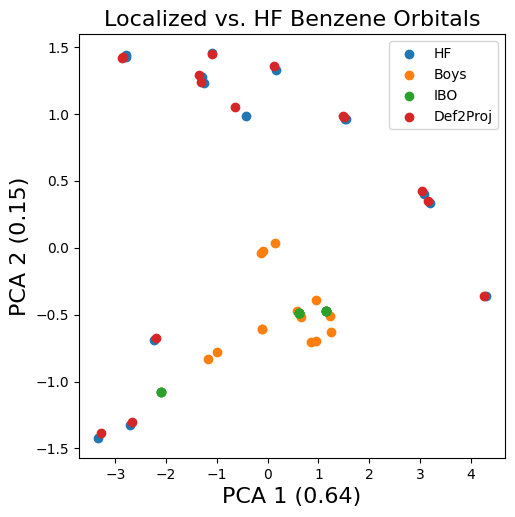

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA

objdct = {}
for orb_typ in ["hf","boys","ibo","proj"]:
    if orb_typ == "hf":
        h5fn = f"{head_dir}/benzene_sto3g_occ.h5"
    elif orb_typ == "proj":
        h5fn = f"{head_dir}/benzene_sto3g_proj_occ.h5"
    else:
        h5fn = f"{head_dir}/benzene_sto3g_occ_{orb_typ}.h5"
    obj = benzene_loc()
    obj.make_predictions(h5fn)
    objdct[orb_typ] = obj

Xreps = []
orbtyps = []
for orb_typ in ["hf","boys","ibo","proj"]:
    obj = objdct[orb_typ]
    Xreps.append(obj.Xrep)
    orbtyps.append([orb_typ]*obj.Xrep.shape[0])
orbtyps = np.hstack(orbtyps)
Xreps = np.vstack(Xreps)

#PCA
plt.figure(figsize=(5.5,5.5))
pca = PCA(n_components=2)
A = pca.fit_transform(Xreps)

annotate=False
dct = {
    "hf":"HF",
    "boys":"Boys",
    "ibo":"IBO",
    "proj":"Def2Proj"
}
annotate=False
for orb_typ in ["hf","boys","ibo","proj"]:
    idx = np.where(orbtyps == orb_typ)[0]
    orb_l = dct[orb_typ]
    sc = plt.scatter(A[idx,0],A[idx,1],label=orb_l)
    #Annotate?
    if annotate:
        for i,row in enumerate(A[idx,:]):
            plt.annotate(f"{orb_typ}_{i}",(row[0]+0.01,row[1]+0.01))
plt.legend()
djvfont = {'fontname':'DejaVu Sans'}
fs=16
pc1, pc2 = np.round(pca.explained_variance_ratio_,2)[:2]
s1 = f"PCA 1 (" + str(pc1) + ")"
s2 = f"PCA 2 (" + str(pc2) + ")"
plt.xlabel(s1,fontsize=fs,**djvfont)
plt.ylabel(s2,fontsize=fs,**djvfont)
# plt.xlim(-6,5)
# plt.ylim(-1.2,2)
plt.title("Localized vs. HF Benzene Orbitals",fontsize=fs,**djvfont)
plt.savefig("figures/benzene_pca_all.png",dpi=500)

In [33]:
#Example code to generate data from the moldens [untested]

# class DataWriter():
#     def __init__(self,fn):
#         if os.path.isfile(fn):
#             os.system(f"rm {fn}")
#         self.h5fn = fn
#         self.onum = 0

#     def write_orb(self,dct):
#         with h5py.File(self.h5fn, "a") as f:
#             for k,v in dct.items():
#                 if isinstance(v,dict):
#                     for k2,v2 in v.items():
#                         f.create_dataset(f"o{self.onum}/{k}_{k2}", data=v2)
#                 else:
#                     f.create_dataset(f"o{self.onum}/{k}", data=v)
#             self.onum += 1

# #Make Benzene Object
# sto3g_fn = "data/benzene_molden/benzene_sto3g.molden"
# mol, mo_ene, mo_coeff, mo_occ, _, _ = molden.load(sto3g_fn)
# obj = OrbExtract(mol=mol,mo_coeff=mo_coeff,mo_ene=mo_ene,mo_occ=mo_occ,label_hl=False)

# #Write occupied
# h5fn = "data/benzene_h5/benzene_sto3g_occ.h5"
# data_writer = DataWriter(h5fn)
# mo_idx = np.where((obj.mo_ene > -1.75)*(obj.mo_occ == 2))[0]
# for i in mo_idx:
#     dct = obj.extract_nlm(i)
#     data_writer.write_orb(dct)